In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import toeplitz
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
%matplotlib qt

In [2]:
N = 3
shots = 20000
R = np.zeros((N, N, N))

R[:, :, 0] = np.identity(N)
for n in range(1, N):
    R[:, :, n] = toeplitz(np.zeros(N), np.concatenate((np.zeros(n), np.ones(1), np.zeros(N-n-1))))

def rho(x, y, R, k):
    xp, yp = [], []
    for i in range(len(x)):
        xp.append(2*int(x[i])-1)
        yp.append(2*int(y[i])-1)
    xp = np.array(xp)
    yp = np.array(yp)
    if k >= 0:
        return xp.T@R[:, :, k]@yp
    else:
        return yp.T@R[:, :, -k]@xp

def islr(xtot):
    N = len(xtot) // 2
    x = xtot[:N]
    y = xtot[N:]
    ssq = 0
    for k in range(1, R.shape[2]):
        ssq = ssq + np.abs(rho(x, y, R, k)) ** 2
        ssq = ssq + np.abs(rho(x, y, R, -k)) ** 2
    ssq += - 100 * np.abs(rho(x, y, R, 0)) ** 2 / (0.9 * N**2)
    return ssq

def compute_expectation(counts):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = islr(bitstring)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(2*N)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, 2*N):
        qc.h(i)
    
    for irep in range(0, p):
        # problem unitary
        fourfactors = np.exp(-1j * 2 * gamma[irep] * np.array([1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1]))
        for k in range(1,N):
            for i in range(0, N-k):
                for j in range(i + 1, N-k):
                    qc.diagonal(list(fourfactors), qubit=[i, j, i + N + k, j + N + k])
                    qc.diagonal(list(fourfactors), qubit=[i + N, j + N, i + k, j + k])
        # Penalty
        fourfactors_pen = np.exp(1j * 100 * 2 * gamma[irep] * np.array([1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1]))
        for i in range(0, N):
            for j in range(i + 1, N):
                qc.diagonal(list(fourfactors_pen), qubit=[i, i + N, j, j + N])

        # mixer unitary
        for i in range(0, 2*N):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation():
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(theta)
        counts = backend.run(qc, seed_simulator=10, 
                             shots=shots).result().get_counts()
        
        return compute_expectation(counts)
    
    return execute_circ

In [3]:
from scipy.optimize import minimize

expectation = get_expectation()

res = minimize(expectation,
                      np.random.uniform(size=50),
                      method='COBYLA')
res

     fun: -108.65523456790123
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 507
  status: 1
 success: True
       x: array([1.22340596, 0.81960317, 1.78036798, 0.57292252, 0.65232377,
       0.58649278, 0.48466298, 0.49143466, 0.46308683, 0.25330621,
       0.68285407, 0.23512367, 1.99423516, 0.13940263, 0.06333833,
       0.90527146, 0.89907947, 0.20712152, 0.67282506, 0.49293851,
       1.36321969, 0.47225754, 0.97936194, 0.04685716, 0.66466557,
       0.6462881 , 0.50513928, 0.53710936, 0.35236733, 0.57319826,
       0.72926547, 0.89125493, 0.48579396, 0.53127239, 0.62781349,
       0.22561007, 0.31761815, 0.90411211, 1.01098221, 0.90168261,
       0.53865462, 0.711601  , 0.68039154, 0.24665417, 0.89093076,
       0.24078089, 0.64167722, 0.22739801, 0.63922728, 0.1634116 ])

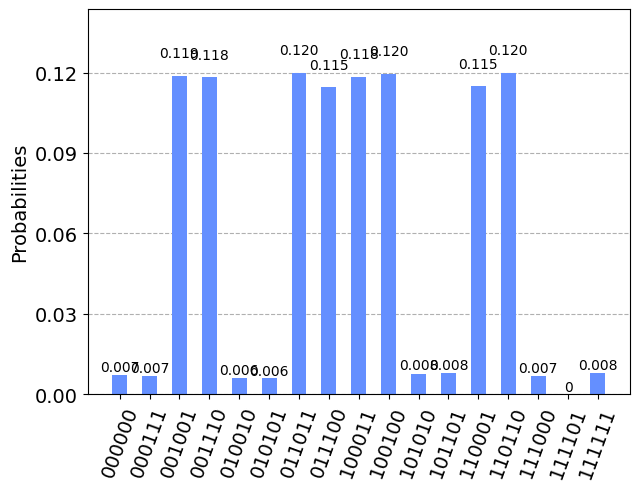


(python:700708): Gtk-CRITICAL **: 14:01:24.598: gtk_tree_view_scroll_to_cell: assertion 'tree_view->priv->tree != NULL' failed

(python:700708): Gtk-CRITICAL **: 14:01:24.616: gtk_tree_view_scroll_to_cell: assertion 'tree_view->priv->tree != NULL' failed

(python:700708): Gtk-CRITICAL **: 14:01:24.633: gtk_tree_view_scroll_to_cell: assertion 'tree_view->priv->tree != NULL' failed

(python:700708): Gtk-CRITICAL **: 14:01:24.651: gtk_tree_view_scroll_to_cell: assertion 'tree_view->priv->tree != NULL' failed

(python:700708): Gtk-CRITICAL **: 14:01:24.664: gtk_tree_view_scroll_to_cell: assertion 'tree_view->priv->tree != NULL' failed

(python:700708): Gtk-CRITICAL **: 14:01:24.681: gtk_tree_view_scroll_to_cell: assertion 'tree_view->priv->tree != NULL' failed

(python:700708): Gtk-CRITICAL **: 14:01:24.698: gtk_tree_view_scroll_to_cell: assertion 'tree_view->priv->tree != NULL' failed

(python:700708): Gtk-CRITICAL **: 14:01:25.486: gtk_tree_view_scroll_to_cell: assertion 'tree_view->pri

In [8]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = shots

qc_res = create_qaoa_circ(res.x)

counts = backend.run(qc_res, seed_simulator=10, shots=shots).result().get_counts()

plot_histogram(counts)

In [5]:
for key, value in counts.items():
    if value / shots > 0.018:
        print(key, value/shots)

100100 0.11955
110110 0.11975
001001 0.1188
100011 0.11845
011011 0.1198
011100 0.11465
110001 0.11495
001110 0.1182


In [6]:
import itertools

all_conf = np.array([np.array(i) for i in itertools.product([0, 1], repeat = 2*N)])

for i in range(all_conf.shape[0]):
    print(all_conf[i][:N], all_conf[i][N:], islr(all_conf[i]))

[0 0 0] [0 0 0] -101.11111111111111
[0 0 0] [0 0 1] -6.345679012345679
[0 0 0] [0 1 0] -10.345679012345679
[0 0 0] [0 1 1] -6.345679012345679
[0 0 0] [1 0 0] -6.345679012345679
[0 0 0] [1 0 1] -10.345679012345679
[0 0 0] [1 1 0] -6.345679012345679
[0 0 0] [1 1 1] -101.11111111111111
[0 0 1] [0 0 0] -6.345679012345679
[0 0 1] [0 0 1] -109.11111111111111
[0 0 1] [0 1 0] -6.345679012345679
[0 0 1] [0 1 1] -2.3456790123456788
[0 0 1] [1 0 0] -2.3456790123456788
[0 0 1] [1 0 1] -6.345679012345679
[0 0 1] [1 1 0] -109.11111111111111
[0 0 1] [1 1 1] -6.345679012345679
[0 1 0] [0 0 0] -10.345679012345679
[0 1 0] [0 0 1] -6.345679012345679
[0 1 0] [0 1 0] -101.11111111111111
[0 1 0] [0 1 1] -6.345679012345679
[0 1 0] [1 0 0] -6.345679012345679
[0 1 0] [1 0 1] -101.11111111111111
[0 1 0] [1 1 0] -6.345679012345679
[0 1 0] [1 1 1] -10.345679012345679
[0 1 1] [0 0 0] -6.345679012345679
[0 1 1] [0 0 1] -2.3456790123456788
[0 1 1] [0 1 0] -6.345679012345679
[0 1 1] [0 1 1] -109.11111111111111
[0 1 1